# Regression with Different Output Format under Various Data Conditions

In this experience, we test the following output format for regression task under several different data coditions.
- Numerical output
- Regression as classification (grid-out)

The data coditions include:
- Sparse (few data)
- Grouped
  - Biased (parallel data)
  - Completely different mode, uncorrelated data (cross)
  - Partially diversed (split)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def draw_func(func_in, x_min=-5, x_max=5, mark='r--', linewidth=1, label='func'):
    n_sample = 100
    X_func = np.linspace(x_min, x_max, n_sample).reshape(n_sample, 1)
    y_func = func_in(X_func)
    plt.plot(X_func, y_func, mark, linewidth=linewidth, label=label)

Generate polynomial data

In [3]:
poly_a1 = 5.0
# poly_a1 = -10.0 # 5.0
#
sin_a = 0.0
# sin_a = 10.0
sin_f = 0.1 # 0.2
#
def func_0(X): # Reference
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 2 + sin_a*np.sin(2.0*np.pi*sin_f*X)
def func_1(X): # Variation 1: parellel
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 30 + sin_a*np.sin(2.0*np.pi*sin_f*X)
def func_2(X): # Variation 2: cross
    return -0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 30 + sin_a*np.sin(2.0*np.pi*sin_f*X)
def func_3(X): # Variation 3: slightly split
    return 0.3 * X**3 + 1.0 * X**2 + (poly_a1)*X + 15 + sin_a*np.sin(2.0*np.pi*sin_f*X)
def func_4(X): # Sine wave~
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 2 + 50.0*np.sin(2.0*np.pi*sin_f*X)

In [4]:
func_dict = dict()
func_dict["f1"] = func_0
# func_dict["f2"] = func_1
# func_dict["f2"] = func_2
func_dict["f2"] = func_3
# func_dict["f2"] = func_4

# Average line
func_dict["f_avg"] = ( lambda X: 0.5*func_dict["f1"](X) + 0.5*func_dict["f2"](X) )

In [5]:
def draw_normal_func(func_dict):
    draw_func(func_dict["f1"], mark='c:', label="f1")
    draw_func(func_dict["f2"], mark='g:', label="f2")
    draw_func(func_dict["f_avg"], mark='m--', label="f_avg")

In [6]:
np.random.seed(42)
m = 100 # 50 # 100 # 200
m_train = m // 5 * 4
print("(m, m_train) = (%d, %d)" % (m, m_train))

# Input
is_gapped = True
# is_gapped = False
#
if not is_gapped:
    X_data = 10 * np.random.rand(m, 1) - 5 # Note: X is randomly sampled, so we don't need to shuffle the data again
else:
    X_data = np.concatenate( (np.linspace(-5.0, -2.0, m//2), np.linspace(2.0, 5.0, m-m//2)) )
    X_data = X_data.reshape((m,1))
    np.random.shuffle(X_data)

# Output
is_multiout = True
# is_multiout = False
if is_multiout:
    m_h = m // 2
    X_data_1 = X_data[:m_h]
    X_data_2 = X_data[m_h:]
    y_data_pure_1 = func_dict["f1"](X_data_1) 
    y_data_pure_2 = func_dict["f2"](X_data_2) 
    y_data_pure = np.vstack([y_data_pure_1, y_data_pure_2])
    print("y_data_pure.shape = %s" % str(y_data_pure.shape))
else:        
    y_data_pure = func_dict["f_avg"](X_data)

# Label (+noise)
n_stddev = 2.0
# n_stddev = 10.0
y_data = y_data_pure + np.random.randn(m, 1) * n_stddev
print("y_data.shape = %s" % str(y_data.shape))

(m, m_train) = (100, 80)
y_data_pure.shape = (100, 1)
y_data.shape = (100, 1)


In [7]:
# Method 1: simply slice
# X_train = X_data[:m_train]
# y_train = y_data[:m_train]
# X_valid = X_data[m_train:]
# y_valid = y_data[m_train:]

# Method 2: shuffle
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape)

(80, 1)


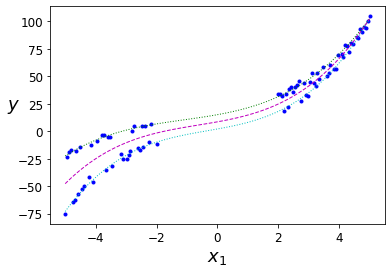

In [9]:
plt.plot(X_train, y_train, "b.")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
# plt.axis([-3, 3, 0, 10])
plt.show()

In [10]:
prediction_error_dict = dict()

def get_prediction_error(func_in, func_dict, name="", x_min=-5, x_max=5, prediction_error_dict=prediction_error_dict):
    n_sample = 100
    X_func = np.linspace(x_min, x_max, n_sample).reshape(n_sample, 1)
    y_func = func_in(X_func).reshape((n_sample,1))
    y_gt = func_dict["f_avg"](X_func).reshape((n_sample,1))
    print("y_func.shape = %s" % str(y_func.shape))
    print("y_gt.shape = %s" % str(y_gt.shape))
#     total_error = np.sqrt(np.square(y_func - y_gt).mean())
    total_error = np.abs(y_func - y_gt).mean()
    prediction_error_dict[name] = total_error
    return total_error

def print_all_prediction_error(prediction_error_dict=prediction_error_dict):
    for _n in prediction_error_dict:
        print("%s: %f" % (_n, prediction_error_dict[_n]))

# Simple FCs (number --> number)

Build the regression model

In [11]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(loss="mean_squared_error", optimizer=optimizer)
# optimizer = keras.optimizers.Adam(lr=0.01)
# model.compile(loss="mean_absolute_error", optimizer=optimizer)

C:\Users\benso\anaconda3\envs\ml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [12]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
3/3 [==============================] - 1s 83ms/step - loss: 2513.3196 - val_loss: 1713.5133
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 2432.6443 - val_loss: 1624.2258
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 2277.2610 - val_loss: 1471.4469
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 1990.8176 - val_loss: 1141.0322
Epoch 5/100
3/3 [==============================] - 0s 30ms/step - loss: 1353.3342 - val_loss: 537.2869
Epoch 6/100
3/3 [==============================] - 0s 23ms/step - loss: 410.1280 - val_loss: 681.7394
Epoch 7/100
3/3 [==============================] - 0s 28ms/step - loss: 814.7443 - val_loss: 333.2197
Epoch 8/100
3/3 [==============================] - 0s 25ms/step - loss: 288.9037 - val_loss: 250.8941
Epoch 9/100
3/3 [==============================] - 0s 54ms/step - loss: 406.9278 - val_loss: 278.2169
Epoch 10/100
3/3 [==============================] - 0s 16ms/step - loss: 

3/3 [==============================] - 0s 21ms/step - loss: 165.9698 - val_loss: 155.2637
Epoch 81/100
3/3 [==============================] - 0s 23ms/step - loss: 165.9246 - val_loss: 153.9041
Epoch 82/100
3/3 [==============================] - 0s 15ms/step - loss: 164.6028 - val_loss: 153.1142
Epoch 83/100
3/3 [==============================] - 0s 17ms/step - loss: 163.4034 - val_loss: 153.9279
Epoch 84/100
3/3 [==============================] - 0s 24ms/step - loss: 164.5736 - val_loss: 154.9342
Epoch 85/100
3/3 [==============================] - 0s 15ms/step - loss: 163.4947 - val_loss: 151.4300
Epoch 86/100
3/3 [==============================] - 0s 18ms/step - loss: 164.0409 - val_loss: 150.6865
Epoch 87/100
3/3 [==============================] - 0s 18ms/step - loss: 162.9648 - val_loss: 153.9727
Epoch 88/100
3/3 [==============================] - 0s 24ms/step - loss: 162.8808 - val_loss: 153.7979
Epoch 89/100
3/3 [==============================] - 0s 14ms/step - loss: 163.4234 - va

Plot the result

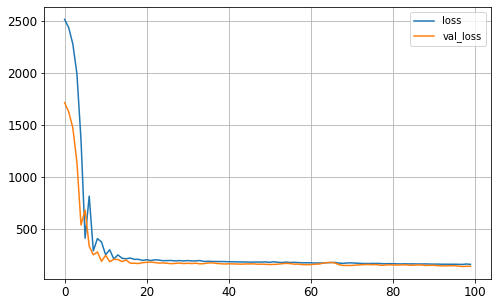

In [13]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

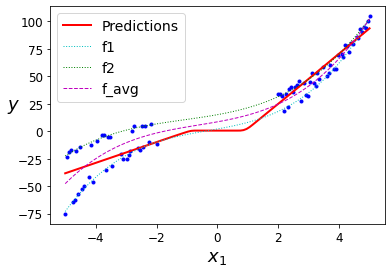

In [14]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new = model.predict(X_new)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

In [15]:
get_prediction_error(model.predict, func_dict, name="num-num")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


6.181107913821904

# Simulated CNN Feature Map (1-D grids, grid --> number)

In [16]:
class num2grid(keras.layers.Layer):
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        #
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
#         print("self.x_grid.shape = %s" % str(self.x_grid.shape))
        #
        super().build(batch_input_shape) # must be at the end
        
    def call(self, X):
        '''
        Input shape:  (batch, X_chanel)
        Output shape: (batch, grid_unit) 
        
        self.x_grid shape: (grid_unit,)
        '''
        gauss_grid = tf.exp( -(self.x_grid - X)**2 / (2.0*self.sigma2) )
        print("X.shape = %s" % str(X.shape))
        print("gauss_grid.shape = %s" % str(gauss_grid.shape))
        return self.activation(gauss_grid)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 
                "units": self.units,
                "x_min": self.x_min,
                "x_max": self.x_max,
                "sigma": self.sigma,
                "activation": keras.activations.serialize(self.activation)}

In [17]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
#     keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

# optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
# model.compile(loss="mean_squared_error", optimizer=optimizer)
optimizer = keras.optimizers.Adam(lr=0.1)
model.compile(loss="mean_absolute_error", optimizer=optimizer)

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


C:\Users\benso\anaconda3\envs\ml\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 0s - loss: 39.5192X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 74ms/step - loss: 41.4232 - val_loss: 33.2073
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 38.8670 - val_loss: 30.5553
Epoch 3/100
3/3 [==============================] - 0s 28ms/step - loss: 33.3601 - val_loss: 26.1243
Epoch 4/100
3/3 [==============================] - 0s 37ms/step - loss: 26.0465 - val_loss: 20.0791
Epoch 5/100
3/3 [==============================] - 0s 28ms/step - loss: 17.9538 - val_loss: 13.8801
Epoch 6/100
3/3 [==============================] - 0s 31ms/step - loss: 16.6502 - val_loss: 9.3716
Epoch 7/100
3/3 [==============================] - 0s 34ms/step - loss: 15.5894 - val_loss: 12.4484
Epoch 8/100
3/3 [==============================] - 0s 27ms/step - loss: 16.3780 - val_loss: 

Epoch 81/100
3/3 [==============================] - 0s 22ms/step - loss: 9.3224 - val_loss: 8.5779
Epoch 82/100
3/3 [==============================] - 0s 22ms/step - loss: 9.0560 - val_loss: 8.8699
Epoch 83/100
3/3 [==============================] - 0s 17ms/step - loss: 9.1861 - val_loss: 8.3532
Epoch 84/100
3/3 [==============================] - 0s 20ms/step - loss: 9.0822 - val_loss: 8.2309
Epoch 85/100
3/3 [==============================] - 0s 13ms/step - loss: 8.8897 - val_loss: 8.6955
Epoch 86/100
3/3 [==============================] - 0s 22ms/step - loss: 8.9881 - val_loss: 8.6258
Epoch 87/100
3/3 [==============================] - 0s 16ms/step - loss: 8.9803 - val_loss: 8.3638
Epoch 88/100
3/3 [==============================] - 0s 17ms/step - loss: 8.8967 - val_loss: 8.1099
Epoch 89/100
3/3 [==============================] - 0s 21ms/step - loss: 8.9614 - val_loss: 8.2004
Epoch 90/100
3/3 [==============================] - 0s 17ms/step - loss: 8.8575 - val_loss: 8.4809
Epoch 91/1

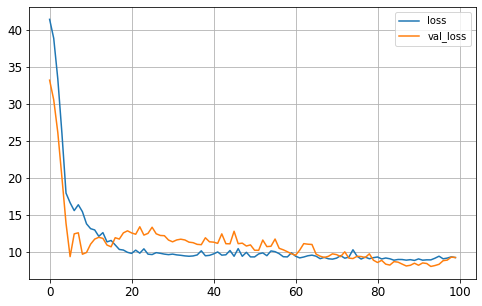

In [19]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


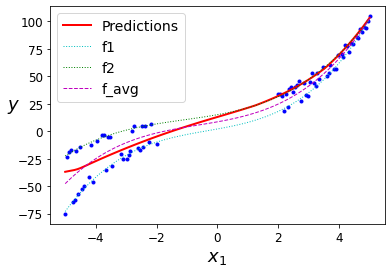

In [20]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new = model.predict(X_new)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

In [21]:
get_prediction_error(model.predict, func_dict, name="grid-num")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


4.25005785293066

# Grid & Regression by Classification (grid --> grid)

In [22]:
class num2grid_np():
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0):
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
        print("self.x_grid = %s" % str(self.x_grid))
        
    def convert(self, X):
        gauss_grid = np.exp( -(self.x_grid - X)**2 / (2.0*self.sigma2) )
#         if len(gauss_grid.shape) == 1:
#             gauss_grid = gauss_grid.reshape([1,-1])
#         grid_sum = np.sum(gauss_grid, axis=1, keepdims=True)
        grid_sum = np.sum(gauss_grid, axis=-1, keepdims=True)
        gauss_grid = gauss_grid / grid_sum
        return gauss_grid
    
    def inv_convert(self, grid):
#         if len(grid.shape) == 1:
#             grid = grid.reshape([1,-1])
#         grid_sum = np.sum(grid, axis=1)
        grid_sum = np.sum(grid, axis=-1)
#         print(grid_sum)
        exp_num = np.sum((self.x_grid * grid), axis=-1) / grid_sum # element-wise
        return exp_num
    
    def get_statistic(self, grid):
        grid_sum = np.sum(grid, axis=-1)
        _mean = np.sum((self.x_grid * grid), axis=-1) / grid_sum # element-wise
        _var  = np.sum( ((self.x_grid.reshape((1,-1)) - _mean.reshape((-1,1)))**2 * grid), axis=-1) / grid_sum # element-wise
        # print("(_mean, _var) = (%f, %f)" % (_mean, _var))
        _stddev = np.sqrt(_var)
        return _mean, _stddev

In [23]:
# class_num = 10 # 10
# n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=20.0) # 20.0
# class_num = 20
# n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=15.0) # 20.0
class_num = 50
n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=6.0) # 5.0 

self.x_grid = [-100.          -95.91836735  -91.83673469  -87.75510204  -83.67346939
  -79.59183673  -75.51020408  -71.42857143  -67.34693878  -63.26530612
  -59.18367347  -55.10204082  -51.02040816  -46.93877551  -42.85714286
  -38.7755102   -34.69387755  -30.6122449   -26.53061224  -22.44897959
  -18.36734694  -14.28571429  -10.20408163   -6.12244898   -2.04081633
    2.04081633    6.12244898   10.20408163   14.28571429   18.36734694
   22.44897959   26.53061224   30.6122449    34.69387755   38.7755102
   42.85714286   46.93877551   51.02040816   55.10204082   59.18367347
   63.26530612   67.34693878   71.42857143   75.51020408   79.59183673
   83.67346939   87.75510204   91.83673469   95.91836735  100.        ]


In [24]:
# grid_1 = n2g.convert(-1.2)
grid_1 = n2g.convert([[-1.2]])
print(grid_1)

[[3.57995092e-60 2.08100846e-55 7.61538914e-51 1.75441300e-46
  2.54444491e-42 2.32314196e-38 1.33530332e-34 4.83176258e-31
  1.10065884e-27 1.57841554e-24 1.42498879e-21 8.09884396e-19
  2.89771784e-16 6.52695532e-14 9.25521826e-12 8.26198061e-10
  4.64304784e-08 1.64264466e-06 3.65852120e-05 5.12966502e-04
  4.52786966e-03 2.51605603e-02 8.80173281e-02 1.93837381e-01
  2.68737559e-01 2.34552834e-01 1.28876722e-01 4.45789421e-02
  9.70748025e-03 1.33077537e-03 1.14848275e-04 6.23972825e-06
  2.13416679e-07 4.59528573e-09 6.22899760e-11 5.31551427e-13
  2.85557712e-15 9.65748361e-18 2.05615356e-20 2.75593262e-23
  2.32542921e-26 1.23526215e-29 4.13082337e-33 8.69632169e-37
  1.15254011e-40 9.61607812e-45 5.05081425e-49 1.67011468e-53
  3.47658354e-58 4.55596654e-63]]


In [25]:
n2g.inv_convert(grid_1)

array([-1.2])

In [26]:
n2g.get_statistic(grid_1)

(array([-1.2]), array([6.]))

### Convert the labels to grid (pre-processing)

In [27]:
y_train_grid = n2g.convert(y_train)
y_valid_grid = n2g.convert(y_valid)

In [28]:
print(y_train_grid.shape)
print(y_valid_grid.shape)

(80, 50)
(20, 50)


In [29]:
model = keras.models.Sequential([
#     keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    keras.layers.Dense(class_num, activation="softmax"),
])

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


C:\Users\benso\anaconda3\envs\ml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [30]:
history = model.fit(X_train, y_train_grid, epochs=100,
                    validation_data=(X_valid, y_valid_grid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 1s - loss: 3.9322X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 87ms/step - loss: 3.9186 - val_loss: 3.8909
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 3.8740 - val_loss: 3.8538
Epoch 3/100
3/3 [==============================] - 0s 41ms/step - loss: 3.8060 - val_loss: 3.8130
Epoch 4/100
3/3 [==============================] - 0s 38ms/step - loss: 3.7259 - val_loss: 3.7564
Epoch 5/100
3/3 [==============================] - 0s 31ms/step - loss: 3.6298 - val_loss: 3.6890
Epoch 6/100
3/3 [==============================] - 0s 28ms/step - loss: 3.5277 - val_loss: 3.6254
Epoch 7/100
3/3 [==============================] - 0s 31ms/step - loss: 3.4243 - val_loss: 3.5572
Epoch 8/100
3/3 [==============================] - 0s 37ms/step - loss: 3.3283 - val_loss: 3.4617
Epoch 9/

3/3 [==============================] - 0s 16ms/step - loss: 2.4388 - val_loss: 2.5654
Epoch 82/100
3/3 [==============================] - 0s 18ms/step - loss: 2.4223 - val_loss: 2.6557
Epoch 83/100
3/3 [==============================] - 0s 21ms/step - loss: 2.4263 - val_loss: 2.6099
Epoch 84/100
3/3 [==============================] - 0s 17ms/step - loss: 2.4259 - val_loss: 2.5765
Epoch 85/100
3/3 [==============================] - 0s 22ms/step - loss: 2.4266 - val_loss: 2.6150
Epoch 86/100
3/3 [==============================] - 0s 17ms/step - loss: 2.4100 - val_loss: 2.6616
Epoch 87/100
3/3 [==============================] - 0s 16ms/step - loss: 2.4130 - val_loss: 2.6071
Epoch 88/100
3/3 [==============================] - 0s 21ms/step - loss: 2.4150 - val_loss: 2.5518
Epoch 89/100
3/3 [==============================] - 0s 14ms/step - loss: 2.4144 - val_loss: 2.5395
Epoch 90/100
3/3 [==============================] - 0s 21ms/step - loss: 2.4318 - val_loss: 2.6036
Epoch 91/100
3/3 [=====

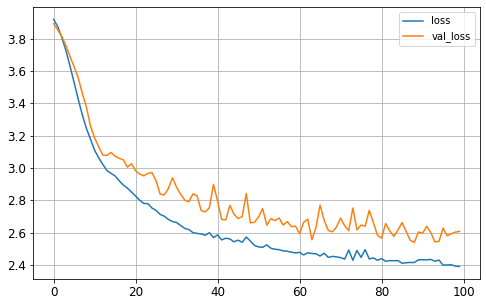

In [31]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


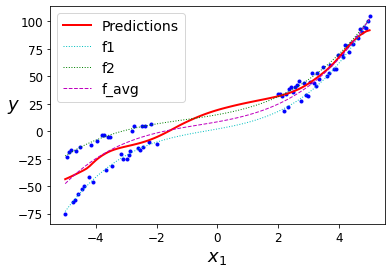

In [32]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new_proba = model.predict(X_new)
# y_new = n2g.inv_convert(y_new_proba)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func((lambda X: n2g.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

In [33]:
get_prediction_error((lambda X: n2g.inv_convert(model.predict(X)) ), func_dict, name="grid-rbc")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


4.808519973065762

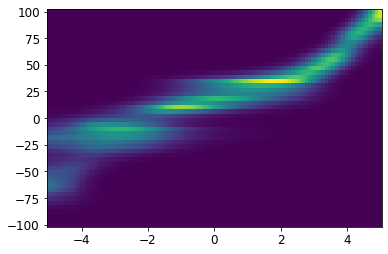

In [34]:
X_new = np.linspace(-5, 5, 100).reshape(100, 1)
y_new_proba = model.predict(X_new)
# y_new = n2g.inv_convert(y_new_proba)
#
xv, yv = np.meshgrid(X_new, np.linspace(n2g.x_min, n2g.x_max, n2g.units))
# print(xv)
# print(yv)
plt.pcolormesh(xv, yv, y_new_proba.T, shading="nearest")

### Draw the 1-sigma boundary line

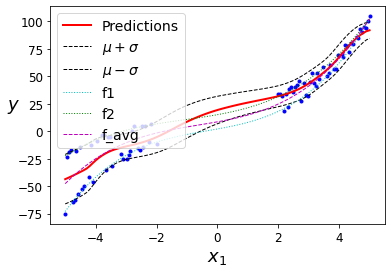

In [35]:
def n_sigma_boundary_line(X, n):
    _mean, _sigma = n2g.get_statistic(model.predict(X))
    return( _mean + n*_sigma)

plt.plot(X_train, y_train, "b.")
#
draw_func((lambda X: n2g.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: n_sigma_boundary_line(X, +1.0) ), mark='k--', linewidth=1, label="$\mu+\sigma$")
draw_func((lambda X: n_sigma_boundary_line(X, -1.0) ), mark='k--', linewidth=1, label="$\mu-\sigma$")
#
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Grid & Regression by Classification + Offset Estimation (grid --> grid,num)

In [36]:
class num2gridOffset_np():
    def __init__(self, units, x_min=-10, x_max=10):
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
        # bins
        x_space = np.average(self.x_grid[1:] - self.x_grid[:-1])
        print("x_space = %f" % x_space)
        x_0 = self.x_grid[0] - 0.5 * x_space
        self.x_bins = [x_0 + _i*x_space for _i in range(len(self.x_grid)+1)]
        print("self.x_grid = %s" % str(self.x_grid))
#         print("self.x_bins = %s" % str(self.x_bins))
        
    def convert(self, X):
        '''
        Convert a batch of number to one-hot class and numerical offset to each grid's center
        (m, 1) --> (m, n_units, 2)
        '''
        X = np.array(X)
        if len(X.shape) <= 1:
            X = X.reshape((-1,1))
        idxs_bin = np.digitize(X, self.x_bins, right=False) 
        idxs_grid = (idxs_bin - 1) + 1*(idxs_bin<= 0) - 1*(idxs_bin>=self.units)
        print(idxs_grid.shape)
        #
        batch_size = X.shape[0]
        grid = np.zeros((batch_size, self.units, 2))
        # Fill in the values
        grid[np.arange(batch_size), idxs_grid.reshape((-1,)), 0] = 1.0
        grid[np.arange(batch_size), :, 1] = X - self.x_grid.reshape((1,-1)) # Offset
        return grid
    
    def inv_convert(self, grid):
        idxs_grid = np.argmax(grid[...,0], axis=1)
        print(idxs_grid.shape)
        #
        batch_size = grid.shape[0]
        offset_est = grid[np.arange(batch_size),idxs_grid,1]
        print(offset_est.shape)
        num_est = self.x_grid[idxs_grid].reshape((1,-1)) + offset_est
        return num_est.reshape((-1,))

In [37]:
class_num = 10 # 10
n2go = num2gridOffset_np(class_num, x_min=-100.0, x_max=100.0) 

x_space = 22.222222
self.x_grid = [-100.          -77.77777778  -55.55555556  -33.33333333  -11.11111111
   11.11111111   33.33333333   55.55555556   77.77777778  100.        ]


In [38]:
# grid_1 = n2g.convert(-1.2)
grid_1 = n2go.convert([[-1.2], [50.5]])
print(grid_1)

(2, 1)
[[[   0.           98.8       ]
  [   0.           76.57777778]
  [   0.           54.35555556]
  [   0.           32.13333333]
  [   1.            9.91111111]
  [   0.          -12.31111111]
  [   0.          -34.53333333]
  [   0.          -56.75555556]
  [   0.          -78.97777778]
  [   0.         -101.2       ]]

 [[   0.          150.5       ]
  [   0.          128.27777778]
  [   0.          106.05555556]
  [   0.           83.83333333]
  [   0.           61.61111111]
  [   0.           39.38888889]
  [   0.           17.16666667]
  [   1.           -5.05555556]
  [   0.          -27.27777778]
  [   0.          -49.5       ]]]


In [39]:
n2go.inv_convert(grid_1)

(2,)
(2,)


array([-1.2, 50.5])

### Convert the labels to grid (pre-processing)

In [40]:
y_train_grid_offset = n2go.convert(y_train)
y_valid_grid_offset = n2go.convert(y_valid)

(80, 1)
(20, 1)


In [41]:
print(y_train_grid_offset.shape)
print(y_valid_grid_offset.shape)

(80, 10, 2)
(20, 10, 2)


In [42]:
inputs = keras.layers.Input(shape=X_train.shape[1:])
#
z = num2grid(5,x_min=-10, x_max=10, sigma=3.0)(inputs)
z = keras.layers.Dense(30, activation="selu")(z)
# Outputs
z_proba = keras.layers.Dense(30, activation="relu")(z)
z_proba  = keras.layers.Dense(class_num, activation="softmax")(z_proba)
z_offset = keras.layers.Dense(class_num, activation="relu")(z)
z_offset = keras.layers.Dense(class_num)(z_offset)
# Concatenate
z_proba  = keras.layers.Reshape([class_num,1])(z_proba)
z_offset = keras.layers.Reshape([class_num,1])(z_offset)
out_cat = keras.layers.Concatenate(axis=-1)([z_proba, z_offset])
#
# Models for trainig and real usage
model = keras.Model(inputs=[inputs], outputs=[out_cat])

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


In [43]:
# Customized loss function

cce = keras.losses.CategoricalCrossentropy(reduction=keras.losses.Reduction.NONE)
# cce(y_true, y_pred).numpy()

def centerLoss_fn(y_true, y_pred):
    #
    y_true_proba = y_true[...,0]
    y_true_value = y_true[...,1]
    #
    y_pred_proba = y_pred[...,0]
    y_pred_value = y_pred[...,1]
    
    #
    cce_loss = cce(y_true_proba, y_pred_proba) / class_num
    #
    y_true_value_est = tf.reduce_sum((y_true_proba * y_true_value), axis=-1)
    y_pred_value_est = tf.reduce_sum((y_true_proba * y_pred_value), axis=-1)
#     y_pred_value_est = tf.reduce_sum((y_pred_proba * y_pred_value), axis=-1)
    value_loss = tf.abs(y_pred_value_est - y_true_value_est)
    
    # Total loss
#     return (0.5*cce_loss + 0.5*value_loss )
    return (0.2*cce_loss + 0.8*value_loss )
#     return (cce_loss)
#     return (value_loss )

In [44]:
# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.05)
model.compile(loss=centerLoss_fn, optimizer=optimizer)

C:\Users\benso\anaconda3\envs\ml\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [45]:
# history = model.fit(X_train, y_train_grid_offset, epochs=100,
#                     validation_data=(X_valid, y_valid_grid_offset))

In [46]:
# import pandas as pd

# pd.DataFrame(history.history).plot(figsize=(8, 5))
# plt.grid(True)
# # plt.gca().set_ylim(0, 1)
# plt.show()

In [47]:
# plt.plot(X_train, y_train, "b.")
# draw_func((lambda X: n2go.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
# draw_normal_func(func_dict)
# plt.xlabel("$x_1$", fontsize=18)
# plt.ylabel("$y$", rotation=0, fontsize=18)
# plt.legend(loc="upper left", fontsize=14)
# # plt.axis([-3, 3, 0, 10])
# plt.show()

In [48]:
# get_prediction_error((lambda X: n2go.inv_convert(model.predict(X)) ), func_dict, name="grid-classOffset")

# Parametric Uncertainty/Distribution Estimation

In this section, we try to estimate uncertainty (actually, fit the dataset distribution) with parametric reprecentation of a distribution instead of a discretized non-parametric representation.

Possible solution includes
- Quantile estimation with pinball loss (statistic)
- Guassian distribution (fit a prabability distribution)

## Quantile Estimation with Pinball Loss (grid --> parameters)

Quantile estimation and pinball loss is based on the concept of statistic, which predict the value based on the rank of samples in the dataset.

The outputs of the model are $(y_{10}, y_{90})$, 10% quantile prediction and 90% quantile prediction, respectively.

In [49]:
# quantile_list = [0.5]
# quantile_list = [0.9]
quantile_list = [0.1, 0.9] # Use hidden layer with 30 neurons
# quantile_list = [0.05, 0.95]
# quantile_list = [0.25, 0.75]
# quantile_list = [0.1, 0.5, 0.9]
# quantile_list = [0.1, 0.3, 0.7, 0.9]
# quantile_list = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9] # remove 0.5
# quantile_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # Should use wider hidden layer (with many neurons) + L1 regularization
num_quantile = len(quantile_list)

In [50]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(60, activation="relu"),
#     keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(num_quantile) # (y10, y90)
])

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


In [51]:
# Customized loss function
def pinballLoss_fn(y_true, y_pred, tau):
    # tau: quantile, tau in [0.0, 1.0]
    # y_true: label mean
    # y_pred: predicted tau quantile
    _q = y_true - y_pred
    return tf.math.maximum( (tau*_q), ((tau-1.0)*_q))
    
def pinballLoss_10_90_fn(y_true, y_pred):
    #
    return pinballLoss_fn(y_true, y_pred[:,0:1], 0.1) + pinballLoss_fn(y_true, y_pred[:,1:2], 0.9)

def pinballLoss_full_fn(y_true, y_pred):
    #
    pinball_losses = tf.stack( [pinballLoss_fn(y_true, y_pred[:, _i:(_i+1)], _tau) for _i, _tau in enumerate(quantile_list)], axis=1)
    return tf.reduce_sum(pinball_losses, axis=1)

In [52]:
# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.1)
# model.compile(loss=pinballLoss_10_90_fn, optimizer=optimizer)
model.compile(loss=pinballLoss_full_fn, optimizer=optimizer)

In [53]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 0s - loss: 50.4136X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 82ms/step - loss: 40.9316 - val_loss: 31.0832
Epoch 2/100
3/3 [==============================] - 0s 20ms/step - loss: 35.9610 - val_loss: 25.7713
Epoch 3/100
3/3 [==============================] - 0s 39ms/step - loss: 27.9703 - val_loss: 18.2532
Epoch 4/100
3/3 [==============================] - 0s 38ms/step - loss: 19.1660 - val_loss: 11.7687
Epoch 5/100
3/3 [==============================] - 0s 40ms/step - loss: 14.4236 - val_loss: 11.4867
Epoch 6/100
3/3 [==============================] - 0s 32ms/step - loss: 13.0992 - val_loss: 13.1650
Epoch 7/100
3/3 [==============================] - 0s 48ms/step - loss: 13.8927 - val_loss: 13.0310
Epoch 8/100
3/3 [==============================] - 0s 37ms/step - loss: 13.2571 - val_loss:

3/3 [==============================] - 0s 17ms/step - loss: 2.5530 - val_loss: 2.5286
Epoch 82/100
3/3 [==============================] - 0s 23ms/step - loss: 2.5480 - val_loss: 2.5001
Epoch 83/100
3/3 [==============================] - 0s 15ms/step - loss: 2.5947 - val_loss: 2.9390
Epoch 84/100
3/3 [==============================] - 0s 21ms/step - loss: 2.9079 - val_loss: 3.0147
Epoch 85/100
3/3 [==============================] - 0s 16ms/step - loss: 2.7428 - val_loss: 2.6129
Epoch 86/100
3/3 [==============================] - 0s 19ms/step - loss: 2.7683 - val_loss: 2.7856
Epoch 87/100
3/3 [==============================] - 0s 17ms/step - loss: 2.8942 - val_loss: 2.8302
Epoch 88/100
3/3 [==============================] - 0s 22ms/step - loss: 2.8194 - val_loss: 3.0351
Epoch 89/100
3/3 [==============================] - 0s 16ms/step - loss: 2.9748 - val_loss: 2.9626
Epoch 90/100
3/3 [==============================] - 0s 19ms/step - loss: 2.6359 - val_loss: 2.5437
Epoch 91/100
3/3 [=====

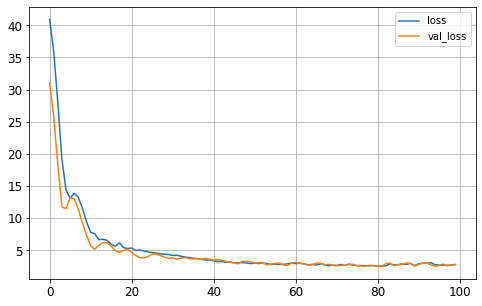

In [54]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

### Draw the mean prediction curve averaged from all quantile predictions.

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


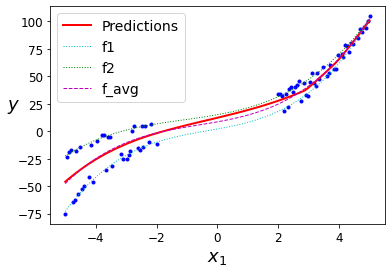

In [55]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
# draw_func((lambda X: model.predict(X)[:,0] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[0]*100))
# draw_func((lambda X: model.predict(X)[:,-1] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[-1]*100))
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

In [56]:
get_prediction_error((lambda X: np.average(model.predict(X), axis=-1) ), func_dict, name="grid-quantileR")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


1.6655323701149605

### Draw first and last quantile curve.

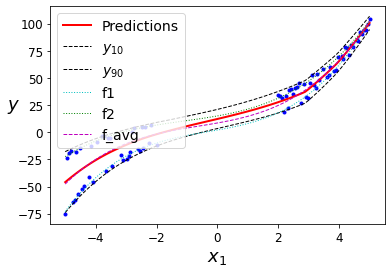

In [57]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: model.predict(X)[:,0] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[0]*100))
draw_func((lambda X: model.predict(X)[:,-1] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[-1]*100))
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

### Draw all quantile predictions

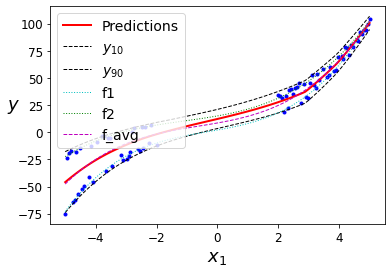

In [58]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
for _idx, _tau in enumerate(quantile_list):
    draw_func((lambda X: model.predict(X)[:,_idx] ), mark='k--', linewidth=1, label="$y_{%d}$" % (_tau*100))
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

## Gaussian Estimation with Gaussian Loss (grid-->parameters)

Gaussain estimation requires the model to predict the mean and variance of a Gaussian distribution of the random variable regarded. The training purpose is to fit a Gaussian distribution to the data distribution (which is not necessay distributed as Gaussian).

One possible solution, derived by BensonHuang, is that the model estimates $(\mu, z)$, where $z=\alpha ^{-1}log(\sigma)$.
The associated loss function can be $L_G(y, (\mu,z)) = 0.5e^{-2\alpha z}(y-\mu)^2 + \alpha z$.

In [59]:
alpha = 1.0
# alpha = 0.01
# alpha = 0.001

In [60]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
#     keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(60, activation="relu"),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(2) # (mu, z)
])

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


In [61]:
# Customized loss function
print("alpha = %f" % alpha)

def GaussianLoss_fn(y_true, y_pred):
    # y_true: label 
    # y_pred: (mu, z), z=log(sigma)
    mu = y_pred[:, 0:1]
    z  = y_pred[:, 1:2]
    #
    en2z = tf.math.exp((-2.0*alpha)*z)
    ymu2 = (y_true - mu)**2
    return (0.5*en2z*ymu2 + alpha*z)

alpha = 1.000000


In [62]:
# Learning rate scheduler
learning_rate_switch_epoch_list = [30, 45]
learning_rate_list = [0.001, 0.01, 0.1]
# learning_rate_switch_epoch_list = [30, 80]
# learning_rate_list = [0.01, 0.1, 0.01]
#
def piecewise_constant_fn(epoch):
    for _i, epoch_s in enumerate(learning_rate_switch_epoch_list):
        if epoch < epoch_s:
            return learning_rate_list[_i]
    return learning_rate_list[-1]

lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

Third training with even greater speed

In [63]:
# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.1)
model.compile(loss=GaussianLoss_fn, optimizer=optimizer)

C:\Users\benso\anaconda3\envs\ml\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [64]:
history = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_valid, y_valid))

Epoch 1/200
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 0s - loss: 612.4542X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 82ms/step - loss: 249.2188 - val_loss: 7.4093
Epoch 2/200
3/3 [==============================] - 0s 21ms/step - loss: 9.2155 - val_loss: 13.5002
Epoch 3/200
3/3 [==============================] - 0s 37ms/step - loss: 14.8855 - val_loss: 17.9408
Epoch 4/200
3/3 [==============================] - 0s 36ms/step - loss: 18.9314 - val_loss: 20.9105
Epoch 5/200
3/3 [==============================] - 0s 31ms/step - loss: 21.5665 - val_loss: 22.6614
Epoch 6/200
3/3 [==============================] - 0s 29ms/step - loss: 23.0477 - val_loss: 23.4325
Epoch 7/200
3/3 [==============================] - 0s 31ms/step - loss: 23.6482 - val_loss: 23.5399
Epoch 8/200
3/3 [==============================] - 0s 36ms/step - loss: 23.6359 - val_loss:

3/3 [==============================] - 0s 20ms/step - loss: 3.3019 - val_loss: 3.2975
Epoch 82/200
3/3 [==============================] - 0s 19ms/step - loss: 3.3233 - val_loss: 3.2905
Epoch 83/200
3/3 [==============================] - 0s 23ms/step - loss: 3.2995 - val_loss: 3.3004
Epoch 84/200
3/3 [==============================] - 0s 14ms/step - loss: 3.3095 - val_loss: 3.2995
Epoch 85/200
3/3 [==============================] - 0s 20ms/step - loss: 3.2880 - val_loss: 3.3202
Epoch 86/200
3/3 [==============================] - 0s 14ms/step - loss: 3.3182 - val_loss: 3.2898
Epoch 87/200
3/3 [==============================] - 0s 16ms/step - loss: 3.2995 - val_loss: 3.2663
Epoch 88/200
3/3 [==============================] - 0s 17ms/step - loss: 3.3080 - val_loss: 3.2564
Epoch 89/200
3/3 [==============================] - 0s 17ms/step - loss: 3.2838 - val_loss: 3.2826
Epoch 90/200
3/3 [==============================] - 0s 22ms/step - loss: 3.3064 - val_loss: 3.3068
Epoch 91/200
3/3 [=====

3/3 [==============================] - 0s 23ms/step - loss: 2.8077 - val_loss: 2.8953
Epoch 164/200
3/3 [==============================] - 0s 14ms/step - loss: 2.8991 - val_loss: 2.9464
Epoch 165/200
3/3 [==============================] - 0s 22ms/step - loss: 2.9440 - val_loss: 3.1267
Epoch 166/200
3/3 [==============================] - 0s 14ms/step - loss: 3.0993 - val_loss: 3.2185
Epoch 167/200
3/3 [==============================] - 0s 21ms/step - loss: 3.0052 - val_loss: 2.9451
Epoch 168/200
3/3 [==============================] - 0s 16ms/step - loss: 2.7909 - val_loss: 3.1140
Epoch 169/200
3/3 [==============================] - 0s 18ms/step - loss: 2.9524 - val_loss: 2.9771
Epoch 170/200
3/3 [==============================] - 0s 17ms/step - loss: 2.9450 - val_loss: 2.9429
Epoch 171/200
3/3 [==============================] - 0s 22ms/step - loss: 2.8353 - val_loss: 3.0110
Epoch 172/200
3/3 [==============================] - 0s 16ms/step - loss: 2.8324 - val_loss: 2.9444
Epoch 173/200


In [65]:
# history = model.fit(X_train, y_train, epochs=145,
#                     validation_data=(X_valid, y_valid), callbacks=[lr_scheduler])

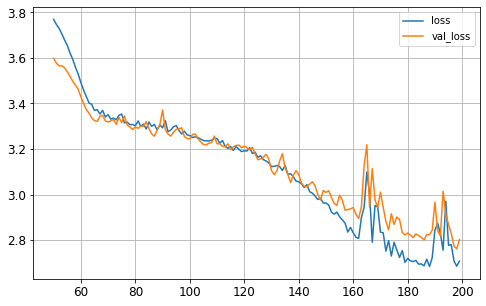

In [66]:
import pandas as pd

# print(history.history)
try:
    lr_list = history.history["lr"]
    del(history.history["lr"])
except:
    pass

pd.DataFrame(history.history)[50:].plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


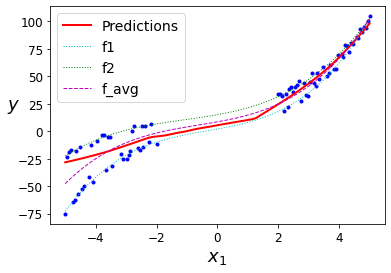

In [67]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: model.predict(X)[:,0] ), mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

In [68]:
get_prediction_error((lambda X: model.predict(X)[:,0] ), func_dict, name="grid-oneGaussian")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


3.419654689547912

### Draw the 1-sigma boundary line

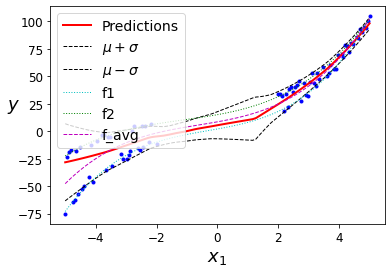

In [69]:
def n_sigma_boundary_line(X, n):
    _y = model.predict(X)
    _mean, _z = _y[:,0:1], _y[:,1:2]
    _sigma = np.exp(alpha*_z)
    return( _mean + n*_sigma)

plt.plot(X_train, y_train, "b.")
#
draw_func((lambda X: model.predict(X)[:,0] ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: n_sigma_boundary_line(X, +1.0) ), mark='k--', linewidth=1, label="$\mu+\sigma$")
draw_func((lambda X: n_sigma_boundary_line(X, -1.0) ), mark='k--', linewidth=1, label="$\mu-\sigma$")
#
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Summary

In [70]:
print_all_prediction_error()

num-num: 6.181108
grid-num: 4.250058
grid-rbc: 4.808520
grid-quantileR: 1.665532
grid-oneGaussian: 3.419655
